In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import torch

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    
    # Iterate over each GPU
    for i in range(num_gpus):
        # Get the GPU name and ID
        gpu_name = torch.cuda.get_device_name(i)
        gpu_id = torch.cuda.get_device_properties(i)
        
        # Print the GPU name and ID
        print(f"GPU {i}: {gpu_name} (ID: {gpu_id})")
else:
    print("No GPUs available.")


GPU 0: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))
GPU 1: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))
GPU 2: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))
GPU 3: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))
GPU 4: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))
GPU 5: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))
GPU 6: NVIDIA RTX A5000 (ID: _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64))

In [18]:
# set cuda:1 as the device
device = torch.device('cuda:1')

class FreezeLinear(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.W = nn.Parameter(torch.ones(5000, 5000), requires_grad=True)
        self.linear = nn.Linear(5000, 5000)
        
    def forward(self, x):
        y = F.linear(x, self.W)
        y = self.linear(y)
        return y

In [19]:
for i in range(1000):
    model = FreezeLinear()
    model = model.to(device)
    input_x = torch.randn(1000, 5000).to(device)
    y = model(input_x)

In [8]:
import torch

def fasterKDP(x, a, b):
    x_shape = x.shape
    a_shape = a.shape
    b_shape = b.shape
    
    
    assert a_shape[0] * b_shape[0] == x_shape[-1], "The shapes of the input tensor and the factors are not compatible"
    # change x[-1] into a[0] b[0]
    x = x.view(-1, a_shape[0], b_shape[0])    
    x = x @ b
    x = torch.permute(x, (0, 2, 1)).contiguous()
    x = x @ a
    x = torch.permute(x, (0, 2, 1)).contiguous()
    
    y_shape = [*x_shape[:-1], a_shape[-1] * b_shape[-1]]
    x = x.view(y_shape)
    return x

x = torch.randn(2, 3, 12)
a = torch.randn(3, 4)
b = torch.randn(4, 5)
y = fasterKDP(x, a, b)
y.shape


torch.Size([2, 3, 20])

In [3]:
import torch
a = torch.randn(1,3, 2, 3)
w = torch.randn(3, 4)
c = a @ w
c.shape 

torch.Size([1, 3, 2, 4])

In [3]:
import torch
a = torch.randn(1,3)
b = torch.randn(3, 4)
c = torch.kron(a, b)
c.shape

torch.Size([3, 12])

In [3]:
from local_models.KronLinear import *
k1l = Kron1Linear(10,20,0,True)
a = torch.randn(10, 10)
k1l.s.data = torch.zeros_like(k1l.s.data)
k1l.update_W_0()
print(k1l.W_0)

torch.Size([2, 4]) torch.Size([2, 4]) torch.Size([5, 5]) torch.Size([10, 20])
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [2]:
import torch.nn as nn
l = nn.Linear(10, 20)
l.weight.shape

torch.Size([20, 10])

In [7]:
import torch
torch.bernoulli(torch.ones(10, 10)* 0.5)

tensor([[1., 0., 1., 1., 1., 0., 1., 0., 1., 1.],
        [1., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 1., 0., 1., 1., 0.],
        [1., 1., 1., 1., 0., 0., 0., 1., 0., 0.],
        [1., 1., 0., 0., 0., 1., 1., 1., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 1., 0., 1., 0., 1., 0., 1., 1., 1.],
        [1., 0., 0., 1., 1., 1., 1., 0., 0., 1.]])

In [6]:
import torch
import torch.nn as nn
a = nn.Linear(10,1, bias=False)
a.weight.data = torch.zeros_like(a.weight.data)
print(a.weight)
optimizer = torch.optim.SGD(a.parameters(), lr=0.1)
y_hat = a(torch.randn(10, 10))
y_true = torch.randn(10, 1)
loss = nn.MSELoss()(y_hat, y_true)
loss.backward(retain_graph=True)  # Add retain_graph=True
optimizer.step()
a.weight

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], requires_grad=True)


Parameter containing:
tensor([[-0.0544, -0.0637,  0.0154, -0.1086, -0.0638, -0.0117, -0.0662, -0.1100,
          0.0795, -0.0969]], requires_grad=True)

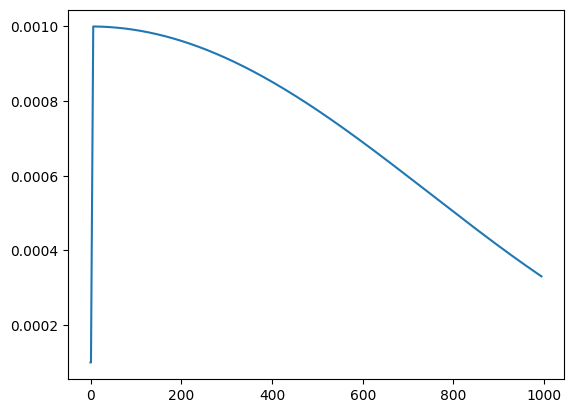

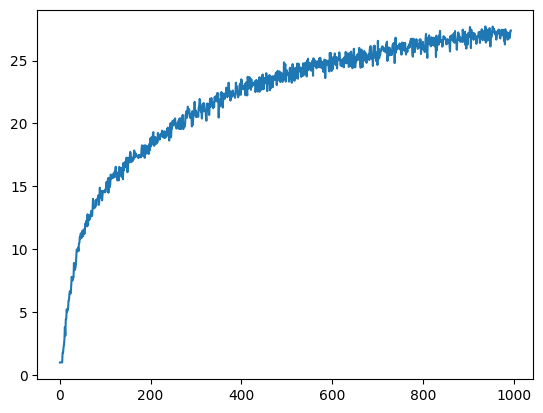

In [4]:
import json
import os
file_path = "/home/zhu.3723/kronvit/output/cifar100_vekron_bias0_rank4/"
file_path = os.path.join(file_path, "log.txt")
test_acc1_array = []
lr_array = []
with open(file_path, "r") as file:
    for line in file:
        data = json.loads(line)
        train_lr = data["train_lr"]
        train_loss = data["train_loss"]
        test_loss = data["test_loss"]
        test_acc1 = data["test_acc1"]
        test_acc5 = data["test_acc5"]
        epoch = data["epoch"]
        n_parameters = data["n_parameters"]
        
        test_acc1_array.append(test_acc1)
        lr_array.append(train_lr)
import matplotlib.pyplot as plt
plt.plot(lr_array)
# show another plot
plt.show()
plt.plot(test_acc1_array)

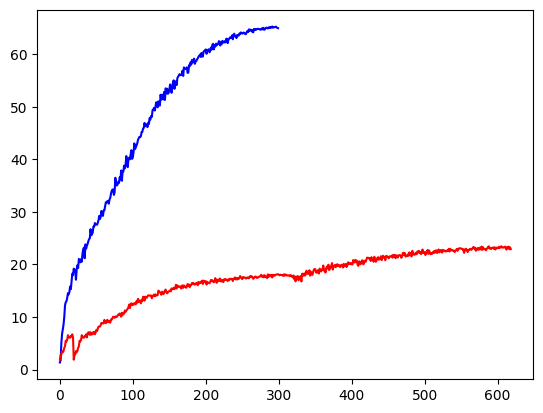

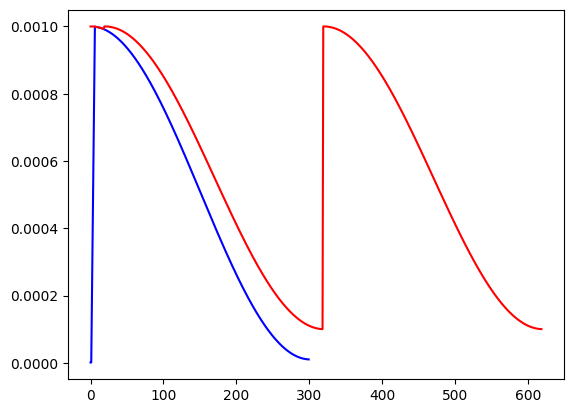

In [3]:
import json

file_path = "/home/zhu.3723/kronvit/output/cifar100_train_common30/log.txt"
test_acc1_array_2 = []
lr_array_2 = []
with open(file_path, "r") as file:
    for line in file:
        data = json.loads(line)
        train_lr = data["train_lr"]
        train_loss = data["train_loss"]
        test_loss = data["test_loss"]
        test_acc1 = data["test_acc1"]
        test_acc5 = data["test_acc5"]
        epoch = data["epoch"]
        n_parameters = data["n_parameters"]
        
        test_acc1_array_2.append(test_acc1)
        lr_array_2.append(train_lr)
import matplotlib.pyplot as plt
plt.plot(test_acc1_array_2, "b")
plt.plot(test_acc1_array, "r")
plt.show()
plt.plot(lr_array_2, "b")
plt.plot(lr_array, "r")